# Standalone network compression

An effective network compression is essential to any strain design computation. Since it may also be of interest outside the context of strain design, this example may help you using the network compression routine independently. Likewise, StrainDesign also offers the integration of GPR rules into the metabolic networks as a separate function.

The network compression routine removes blocked reactions, removes conservation relations and then alternately lumps **coupled** reactions (compress_model_coupled, using a sparse integer RREF nullspace algorithm by default) and **parallel** reactions (compress_model_parallel). The compression returns a compressed network and a list of so-called "compression maps". Each map consists of a dictionary that contains complete information for reversing the compression steps successively and expand information obtained from the compressed model to the full model. Each entry of each map contains the id of a compressed reaction, associated with the original reaction names and their factor (provided as a rational number) with which they were lumped.

The default backend is backend='sparse_rref' (pure Python, no extra dependencies). A legacy Java-based backend backend='efmtool_rref' is also available via pip install straindesign[java].

Furthermore, the user can select reactions that should be exempt from the parallel compression. In the following, we provide the code snippet that can be used to call the compression.

In [1]:
from straindesign import compress_model, remove_dummy_bounds
import cobra
import logging
logging.basicConfig(level=logging.INFO)

# load model
iml1515 = cobra.io.load_model('iML1515')
# replace dummy bounds with infinite
logging.info(f"Replacing dummy bounds of +/- 1000 with infinite.")
remove_dummy_bounds(iml1515)
logging.info(f"The original model contains {len(iml1515.reactions)} reactions.")
cmp_map = compress_model(iml1515)

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-12-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-12-09
INFO:root:Replacing dummy bounds of +/- 1000 with infinite.
INFO:root:The original model contains 2712 reactions.
INFO:straindesign.compression:  Removing blocked reactions.
INFO:straindesign.compression:  Converting coefficients to rationals.
INFO:straindesign.compression:  Removing conservation relations.
INFO:straindesign.compression:  Compression 1: Lumping coupled reactions.
INFO:straindesign.compression:Compression complete: 6 iterations, 234 zero-flux, 602 contradicting, 970 coupled, 1250 unused metabolites
INFO:straindesign.compression:  Reduced to 1237 reactions.
INFO:straindesign.compression:  Compression 2: Lumping parallel reactions.
INFO:straindesign.compression:  Reduced to 1217 reactions.
INFO:straindesign.compression:  Compression 3: Lumping coupled reactions.
INFO:straindesign.compression:Compression complete: 3 iterations, 0 zero-flux, 0 contradicting, 4 coupled, 2 unused metabolites
INF

Here, the original model of iML1515 was compressed from 2712 to 1213 reactions in 4 steps. The greatest reduction in size is achieved in the first step. Still, the benefit of the parallel compression should not be underestimated since it removes superfluous degrees of freedom in the model that don't add significant information. The resulting compression maps can be used to translate data between the compressed and the original network.

In [2]:
# Let us track the compression of the ADK4 reaction
orig_reac = 'ADK4'

for i,c in enumerate(cmp_map):
    logging.info(f"Compression step {i+1} was {['parallel' if c['parallel'] else 'linear'][0]}.")
    lumped_reaction = [k for k,v in c['reac_map_exp'].items() if orig_reac in v][0]
    if len(c['reac_map_exp'][lumped_reaction]) == 1:
        logging.info(f"Reaction '{orig_reac}' was not affected by this reaction")
    else:
        logging.info(f"Reaction '{orig_reac}' was lumped to {lumped_reaction} with the coefficients {c['reac_map_exp'][lumped_reaction]}.")
    orig_reac = lumped_reaction

INFO:root:Compression step 1 was linear.
INFO:root:Reaction 'ADK4' was lumped to ADK4*NTP10 with the coefficients {'ADK4': Fraction(1, 1), 'NTP10': Fraction(-1, 1)}.
INFO:root:Compression step 2 was parallel.
INFO:root:Reaction 'ADK4*NTP10' was not affected by this reaction
INFO:root:Compression step 3 was linear.
INFO:root:Reaction 'ADK4*NTP10' was not affected by this reaction
INFO:root:Compression step 4 was parallel.
INFO:root:Reaction 'ADK4*NTP10' was lumped to ADK4*NTP10*NADPHXD*NADPHXE*NADPHHR*NADPHHS*NADHHR*NADHXE*NADHHS*NADHXD with the coefficients {'ADK4*NTP10': 1, 'NADPHXD*NADPHXE*NADPHHR*NADPHHS': 1, 'NADHHR*NADHXE*NADHHS*NADHXD': 1}.


## Standalone GPR-integraton

GPR rules can be introduced to the metabolic model in a way that the logical GPR-terms are reflected and the gene presence or absence can be simulated by setting flux bounds. This can be useful to investigate the space of feasible steady-state flux vectors after gene knockouts or be used to investigate the role of genes in different elementary flux modes or vectors.

In [3]:
from straindesign import extend_model_gpr
import cobra
import logging
logging.basicConfig(level=logging.INFO)
# load model
e_coli_core = cobra.io.load_model('e_coli_core')
# extend model with GPR rules using gene-IDs
extend_model_gpr(e_coli_core)
# printing the last 10 reactions (corresponding to genes and GPR rules) of the GPR-extend network
logging.info('The first 95 reactions are original reactions from e_coli_core. All other reactions result from the integration of GPR rules.')
logging.info('Here, we only print the last 10 reactions of the model for showcasing.')
[print(r) for r in e_coli_core.reactions[-10:]];

INFO:root:The first 95 reactions are original reactions from e_coli_core. All other reactions result from the integration of GPR rules.
INFO:root:Here, we only print the last 10 reactions of the model for showcasing.


R_g_b2276_and_g_b2277_and_g_b2278_and_g_b2279_and_g_b2280_and_g_b2281_and_g_b2282_and_g_b2283_and_g_b2284_and_g_b2285_and_g_b2286_and_g_b2287_and_g_b2288: g_b2276 + g_b2277 + g_b2278 + g_b2279 + g_b2280 + g_b2281 + g_b2282 + g_b2283 + g_b2284 + g_b2285 + g_b2286 + g_b2287 + g_b2288 --> g_b2276_and_g_b2277_and_g_b2278_and_g_b2279_and_g_b2280_and_g_b2281_and_g_b2282_and_g_b2283_and_g_b2284_and_g_b2285_and_g_b2286_and_g_b2287_and_g_b2288
b3962:  --> g_b3962
R0_g_b1602_and_g_b1603_or_g_b3962: g_b3962 --> g_b1602_and_g_b1603_or_g_b3962
R1_g_b1602_and_g_b1603_or_g_b3962: g_b1602_and_g_b1603 --> g_b1602_and_g_b1603_or_g_b3962
b0451:  --> g_b0451
R0_g_b0451_or_g_s0001: g_s0001 --> g_b0451_or_g_s0001
R1_g_b0451_or_g_s0001: g_b0451 --> g_b0451_or_g_s0001
b0114:  --> g_b0114
b0115:  --> g_b0115
R_g_b0114_and_g_b0115_and_g_b0116: g_b0114 + g_b0115 + g_b0116 --> g_b0114_and_g_b0115_and_g_b0116


### Gene perturbation studies

GPR-extended models can be used to study how single or multiple gene-KOs affect the steady-state flux space. We can therefore integrate the GPR-rules in the model and then plot flux spaces that take into account knockouts. In the plots below, we show how knocking out the gene *lpd* affects bacterial growth and AKG yields.

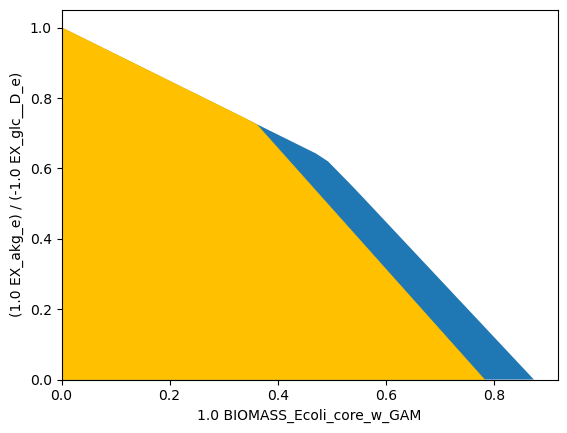

In [4]:
import straindesign as sd
import cobra
import logging
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)
# load model
e_coli_core = cobra.io.load_model('e_coli_core')
# extend model with GPR rules using gene-names instead of IDs.
sd.extend_model_gpr(e_coli_core, use_names=True)

# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(e_coli_core,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_akg_e','-EX_glc__D_e')),
                                               show=False);
# plotting designed strain
_,          _,      plot2 = sd.plot_flux_space(e_coli_core,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_akg_e','-EX_glc__D_e')),
                                               constraints=['lpd = 0'],
                                               show=False);
plot2.set_facecolor('#FFC000')
plot2.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot2.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot2.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

The blue shape represents the wild type and the yellow shape the *lpd* knockout strain flux space. The model predicts that the knockout will not affect the globally attainable α-ketoglutarate yield, but reduces the maximal possible growth rate. At higher growth rates, α-ketoglutarate yield is reduced.